In [1]:
import numpy as np
import pandas as pd

import cornac
from cornac.eval_methods import RatioSplit
from cornac.data import TextModality
from cornac.data.text import BaseTokenizer
from cornac.models import CTR
from cornac.metrics import MAE,RMSE,MSE,FMeasure,Precision,Recall,NDCG,NCRR,MRR,AUC,MAP

FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.


In [2]:
with open ('/Users/pigr/Desktop/cornac_dataset/mind_10K.csv') as mind_file:
    mind = pd.read_csv(mind_file)
mind.head()

,user_id,item_id,rating,date,category,url,text,entities,sentiment,complexity,publication_date,entities_base,enriched_entities,story
0,U13740,N55189,1,2019-10-15,tv,https://assets.msn.com/labs/mind/AAIORni.html,"We’d like to solve the puzzle, Pat: Blair Davi...","[{'text': 'Cardiff', 'alternative': ['Cardiff'...",0.091856,62.17,1.571098e+12,"[{'text': 'Pat', 'start_char': 31, 'end_char':...","[{'text': 'Cardiff', 'alternative': ['Cardiff'...",766
1,U13740,N42782,1,2019-10-19,sports,https://assets.msn.com/labs/mind/AAJ1mE9.html,The Yankees forced a Game 6 on Friday as it to...,"[{'text': 'second', 'alternative': ['second'],...",0.028105,73.92,1.571443e+12,"[{'text': 'Yankees', 'start_char': 4, 'end_cha...","[{'text': 'second', 'alternative': ['second'],...",444
2,U13740,N34694,1,2019-10-19,tv,https://assets.msn.com/labs/mind/AAIZa64.html,A living legend. Rosie O’Donnell gave Us Weekl...,"[{'text': '90', 'alternative': ['90'], 'freque...",0.330846,81.63,1.571443e+12,"[{'text': 'Us Weekly', 'start_char': 38, 'end_...","[{'text': '90', 'alternative': ['90'], 'freque...",1331
3,U13740,N45794,1,2019-10-23,news,https://assets.msn.com/labs/mind/AAJcQKF.html,Four American Airlines flight attendants were ...,"[{'text': 'Four', 'alternative': ['Four'], 'fr...",0.044328,61.26,1.571789e+12,"[{'text': 'Four', 'start_char': 0, 'end_char':...","[{'text': 'Four', 'alternative': ['Four'], 'fr...",0
4,U13740,N18445,1,2019-10-27,sports,https://assets.msn.com/labs/mind/AAJpMXE.html,Michigan sent a funny tweet on Saturday night ...,"[{'text': 'two', 'alternative': ['two'], 'freq...",0.166667,90.29,1.572134e+12,"[{'text': 'Michigan', 'start_char': 0, 'end_ch...","[{'text': 'two', 'alternative': ['two'], 'freq...",0


In [3]:
# pre-process data to initialize ctr model
mind_feedback = mind.loc[:, ['user_id','item_id','rating']]
# feedback = cornac.data.Dataset.from_uir(mind_feedback.itertuples(index=False))
feedback = mind_feedback.apply(lambda x: tuple(x), axis=1).values.tolist()
text = list(mind['text'])
item_ids = list(mind['item_id'])
# Instantiate a TextModality, it makes it convenient to work with text auxiliary information
item_text_modality = TextModality(
    corpus=text,
    ids=item_ids,
    tokenizer=BaseTokenizer(sep=" ", stop_words="english"),
    max_vocab=8000,
    max_doc_freq=0.5,
)

# Define an evaluation method to split feedback into train and test sets
mind_ratio_split = RatioSplit(
    data=feedback,
    test_size=0.2,
    exclude_unknowns=True,
    item_text=item_text_modality,
    verbose=True,
    seed=123,
    rating_threshold=0.5,
)


rating_threshold = 0.5
exclude_unknowns = True
---
Training data:
Number of users = 272
Number of items = 3942
Number of ratings = 7911
Max rating = 1.0
Min rating = 1.0
Global mean = 1.0
---
Test data:
Number of users = 234
Number of items = 915
Number of ratings = 1336
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 272
Total items = 3942


/Users/pigr/cornac/lib/python3.10/site-packages/cornac/data/dataset.py:361: UserWarning: 89 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/Users/pigr/cornac/lib/python3.10/site-packages/cornac/data/dataset.py:361: UserWarning: 3 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


In [4]:
# Instantiate HFT model
ctr = cornac.models.CTR(
    k=50,
    lambda_u=0.01,
    lambda_v=1,
    eta=0.01,
    a=1,
    b=0.01,
    max_iter=50,
    trainable=True,
    verbose=True,
    init_params=None,
    seed=123,
)

# Instantiate MSE for evaluation
metrics = [MAE(), RMSE(), MSE(),FMeasure(k=300),Precision(k=300),
           Recall(k=300), NDCG(k=300), NCRR(k=300),
           MRR(),AUC(), MAP()]

# Put everything together into an experiment and run it
cornac.Experiment(
    eval_method=mind_ratio_split, models=[ctr], metrics=metrics, user_based=False
).run()


[CTR] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

[CTR] Evaluation started!


Rating:   0%|          | 0/1336 [00:00<?, ?it/s]

Ranking:   0%|          | 0/234 [00:00<?, ?it/s]


TEST:
...
    |    MAE |    MSE |   RMSE |    AUC | F1@300 |    MAP |    MRR | NCRR@300 | NDCG@300 | Precision@300 | Recall@300 | Train (s) | Test (s)
--- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + -------- + -------- + ------------- + ---------- + --------- + --------
CTR | 0.0000 | 0.0000 | 0.0000 | 0.6305 | 0.0086 | 0.0144 | 0.0399 |   0.0204 |   0.0708 |        0.0044 |     0.2482 |   63.7858 |   0.4880



# one-hot encoding of categories

In [5]:
categories = set(mind['category'])
one_hot = dict()
for i,c in enumerate(categories):
  one_hot[c] = np.zeros(len(categories))
  one_hot[c][i] = 1

In [6]:
one_hot

{'video': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'autos': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'health': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'foodanddrink': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'music': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'movies': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tv': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'sports': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 'travel': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 'weather': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 'finance': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 'news': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 'lifestyle': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 'entertai

In [7]:
def encode(keys):
    arr = []
    for k in keys:
        arr.append(one_hot.get(k))
    return arr

In [8]:
# for user idx=0
recommendations, scores = ctr.rank(0)

In [9]:
# inverse top 10, and compute the recall
item_rank = np.append(np.flip(recommendations[:10]),recommendations[10:])
item_scores = scores[item_rank]
import diversity_mind
rank = diversity_mind.Rank(item_rank, item_scores)
rank.ranking_eval(
            model = ctr,
            metrics = [Recall(k=300)],
            train_set=ctr.train_set,
            test_set=mind_ratio_split.test_set,
            val_set=None,
            rating_threshold=0.5,
            exclude_unknowns=True,
            verbose=False,
    )

[0.14222040822712428]

## Now select top 5 items
formula: 0.5 * calibration metric + 0.5 * intra_distance

In [10]:
# import radio metric
import diversity
r = diversity.Retrieval(model=ctr,data = mind,UIDX = 0,TOPK = 10,feature = 'category', test_set=mind_ratio_split.test_set)
d = diversity.Diversity(r.get_history(), r.get_recy())
i = diversity.IntraDiverse()

In [11]:
r.get_history()[:5]

['finance', 'news', 'finance', 'news', 'health']

In [12]:
r.get_recy()

['finance',
 'news',
 'lifestyle',
 'news',
 'tv',
 'news',
 'news',
 'travel',
 'news',
 'autos']

In [13]:
# select 5 from top 10 items
# find all possible combinations
import itertools
combinations_idx = []
for c in itertools.combinations(recommendations[:10],5):
    combinations_idx.append(c)

combinations = []
for c in itertools.combinations(r.get_recy(),5):
    combinations.append(c)

print(len(combinations_idx))
print(len(combinations))

252
252


In [15]:
result = []
for c in combinations:
    radio = diversity.Diversity(c, r.get_history()[:5]).compute()
    intra = diversity.IntraDiverse()._single_user_distance(encode(c))
    result.append(0.5*radio + 0.5*intra)

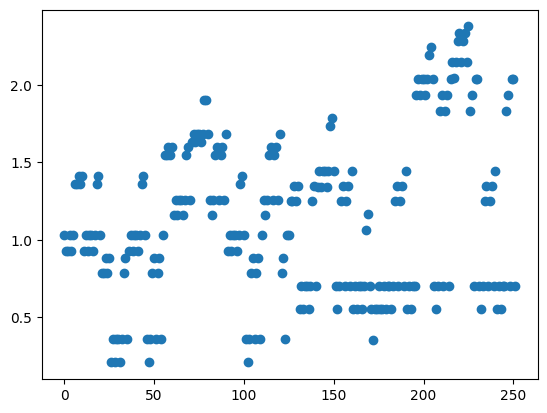

In [16]:
import matplotlib.pyplot as plt

x = np.arange(len(combinations))
plt.plot(x, result,'o')
plt.show()

In [17]:
max_idx = np.argmax(result)
combinations[max_idx]

('lifestyle', 'tv', 'travel', 'news', 'autos')

In [18]:
item_rank = np.append(np.append(combinations_idx[max_idx],list(set(recommendations[:10]) - set(combinations_idx[max_idx]))),recommendations[10:])
item_scores = scores[item_rank]
import diversity_mind
rank = diversity_mind.Rank(item_rank, item_scores)
rank.ranking_eval(
            model = ctr,
            metrics = [Recall(k=300)],
            train_set=ctr.train_set,
            test_set=mind_ratio_split.test_set,
            val_set=None,
            rating_threshold=0.5,
            exclude_unknowns=True,
            verbose=False,
    )

[0.14222040822712428]

In [19]:
item_rank[:10]

array([  28,    0, 1139,  226,  328,  361,  780,  110,  912,  379])

In [20]:
recommendations[:10]

array([ 379,  912,   28,  780,    0,  361,  110, 1139,  226,  328])

### if I also consider recall
formula: 0.25 * calibration metric + 0.25 * intra_distance + 0.5 * recall

In [21]:
def recall(idx):
    item_rank = np.append(np.append(combinations_idx[idx],list(set(recommendations[:10]) - set(combinations_idx[idx]))),recommendations[10:])
    item_scores = scores[item_rank]
    import diversity_mind
    rank = diversity_mind.Rank(item_rank, item_scores)
    return rank.ranking_eval(
            model = ctr,
            metrics = [Recall(k=300)],
            train_set=ctr.train_set,
            test_set=mind_ratio_split.test_set,
            val_set=None,
            rating_threshold=0.5,
            exclude_unknowns=True,
            verbose=False,
    )[0]

In [22]:
result = []
for idx,c in enumerate(combinations):
    radio = diversity.Diversity(c, r.get_history()[:5]).compute()
    intra = diversity.IntraDiverse()._single_user_distance(encode(c))
    result.append(0.25*radio + 0.25*intra + 0.5*recall(idx))

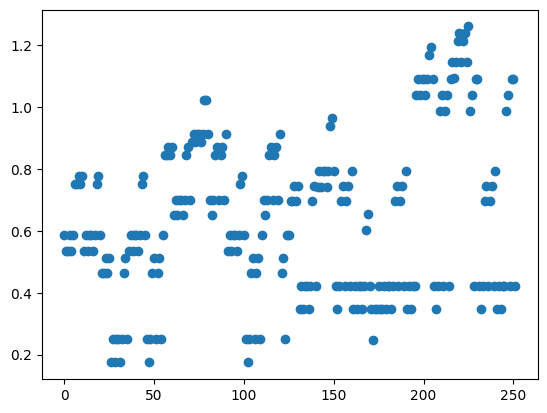

In [23]:
x = np.arange(len(combinations))
plt.plot(x, result,'o')
plt.show()

In [24]:
max_idx = np.argmax(result)
combinations[max_idx]

('lifestyle', 'tv', 'travel', 'news', 'autos')

In [25]:
result[max_idx]

1.2593325218586284

In [26]:
r.get_history()[:5]

['finance', 'news', 'finance', 'news', 'health']